#### 🍀thank you  all helpers 
[@Yoshi_K ](https://www.kaggle.com/yoshikuwano/eda-non-annotated-starfish)  [@CAMARO](https://www.kaggle.com/bamps53/create-annotated-video#kln-23) 
[@tensor_choko](https://www.kaggle.com/tensorchoko/tensorflow-eda-for-beginner-jp-en/notebook)

 In this notebook I tried to explain all the things that are needed for us to kick start our model building , I kept my comments as  begginer friendly as I can , explaining all facts like a conversation , hope it will help you to understand this interesting problem <br>
 So.. let's dive in...🏊‍🏊‍
 # 🐠🐟🐡🦑🐙🦈🐬🐳🐋🦀🐚🏊‍♀️🍀☘💺🚤⚓🏝🌊🌊 🐠🐟🐡

<br>
<br>
<br>

# 💢 Basic info & requirements for this competition in simple language 😅
<br>
<br>


![](https://505488.smushcdn.com/2242995/wp-content/uploads/site_assets/crown_of_thorns_starfish_5457578925_.jpg?lossy=1&strip=1&webp=1)


>**Goal** : there is one species of star fish which is eating corals and destroying the great barrier reef , we have to find that COTS named star fish (above fig. ) by creating an object detection model which can work in real time <br>
**What we have with us to analyse and create model ?**  : well , in   our data we have <br>
.  1. one API named inside folder greatbarrier reef <br>
.  2. train_images : these are basically 3 videos whose images are splitted into video_0 , video_1 , video_2 folders <br>
.  3. test, train, sample submission csvs are there <br>
.  4. example test.npy is also there : <br>

>**what we have to actually do here** : for training there is a image of corals and there is marking/annotation ( a sqare bounding box ) is given in image at specific position and size , i.e. COTS fish is marked in bounding box using annotations , what we have to do is create a model which will train based on the given annotations and while testing it should create the annotations/bounding boxes on it's own to find where the actual COTS fish is, there in the given image,
further more the entire system should work in real time which means, when some sea diver is taking video clip of corals deep down sea our algorithm should detect the object from that video...this is what expected by user as per my understanding.

>**what we have to submit** : as usual.. we have to predict y but this time y is  annotation and submit it in submission.csv file ..  [refer code requirements](https://www.kaggle.com/c/tensorflow-great-barrier-reef/overview/code-requirements)<br>
>**How our submission will be evaluated** : using F2 score , i.e False positivity rate is accepted , F2= 5PR/(4P+R )

if someone has any doubt or any other view regarding the question understanding or if something is missing , then please comment and share your views. because it will help me to explore the data more effectively.

# 💥EDA for the <strong> Great barrier Reef </strong> dataset

#### 💠importanting libraries 

In [ ]:
import os
import cv2
import ast
import json
import subprocess
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Video  


### 💠Importing Data 

In [ ]:
main_path= '../input/tensorflow-great-barrier-reef'

In [ ]:
tdf= pd.read_csv(main_path + '/train.csv')
tdf.head()

so train.csv explain us the parameters to connect the images in the video_0,video_1 and video_2 folders, 
`video_id` -- explain us from which folder the file is , if video_id val ==0 then it belongs to video_0 and so on..
`sequence` -- 

In [ ]:
tdf.info()

In [ ]:
tdf.describe()

### 💠 Analysis for prediction Y
let's see what exactly we have to predict 

In [ ]:
Tdf=pd.read_csv(main_path + '/test.csv')
Tdf.head()

hmm... annotations is the key here,
let's see what this feature's specifications are...🤔

In [ ]:
tdf.annotations.iloc[133:200]

In [ ]:
a=tdf.annotations.describe()
print(a)
tdf.annotations.unique()

#### ⭕annotations per video 

In [ ]:
for video_id in tdf['video_id'].unique():
    print(f'video_id: {video_id}')
    print(f'no. of images without annotations:  {sum(tdf[tdf["video_id"]==video_id]["annotations"]== "[]")}')
    print(f'no. of images with annotations:  {sum(tdf[tdf["video_id"]==video_id]["annotations"] != "[]")}\n')

#### ⭕percentage of annatotation 

In [ ]:
a1=2143/(4565 + 2143)*100 ; a2=2099/(6133+2099)*100 ;a3=677/(7884+677)*100 ; a=(2143 +2099+677)/23501*100
print(f"total % annotations in video0 : {a1}% \ntotal % annotations in video1: {a2}% \ntotal % annotations in video2 : {a3}% \nToal % annotations  : {a}%" )

ok..  we got something very bad here ..
for every annotation we have specific co-ordinates { x ,y, width and height} but lot's of annotations are empty `only 20.93%` images are annoted and that's not at all interesting 😂😂 bcoz it's going to force us to use some advanced algorithms to create model from very less training dataset ... 
<br>
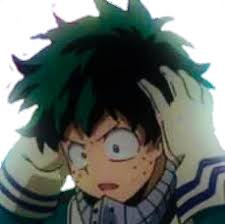 <br>
just kidding 😂

ok.. let's see what we have in our sample submission example

### 💠 Expected output annotation

**What's there in the examples submission files ????**

#### 1. example_sample_submission.csv 

In [ ]:
sdf=pd.read_csv("../input/tensorflow-great-barrier-reef/example_sample_submission.csv")
sdf

so here for $0^{th}$ annotation :<br> 
`0.99` -- it's showing that there is bbox at given position and with given size confirming it's existence with CI of 99% or simply put it is probability of bbox being present there , <br>
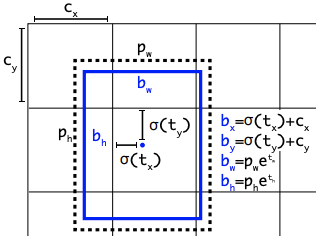<br>
`123` -- is x co-ordnate it's  $b_x$,<br> 
`456` -- is y co-ordinate it's $b_y$,<br>
`1` is weidth it's $b_w$'<br>
`1` is height its $b_h$,

the image itself is solution but hard to implement 😂

#### 2. example_test.npy

In [ ]:
sample_test = np.load('../input/tensorflow-great-barrier-reef/example_test.npy') 
#sample_test

# 💥Preprocessing and feature engineering

In [ ]:
# Change the type of 'annotations' from str to list
tdf["annotations"] = tdf["annotations"].apply(ast.literal_eval) # str -> list

`Note:` our train.csv only possess video_id , sequence, video frame , image sequence, image id but actual images are in video_0,1,2 folders we need to combine them , one way is copying path of images as per video_id ... thanks to Yoshi_k he has done it for us by writting below code    

#### 🔅Adding image path to dataset

In [ ]:

# Add columns of image path and number of bboxes, and the difference.
tdf['image_path'] = main_path + '/train_images/video_'+ tdf['video_id'].astype(str) + '/' + tdf['video_frame'].astype(str) + ".jpg"
tdf['num_bboxes'] = tdf['annotations'].apply(lambda x: len(x))
tdf.head()

#### 🔅 new features and their insights 

In [ ]:
tdf.sequence_frame.unique()

In [ ]:
a=tdf.num_bboxes.unique()
#display(a)
tdf['num_bboxes'][tdf['num_bboxes']==0].count()

In [ ]:
fig ,ax= plt.subplots(3,1,figsize=(20,30))
sns.set_style('darkgrid')
sns.scatterplot(data=tdf , y='num_bboxes',x='video_frame' , hue ='video_id',ax=ax[0] ,size='num_bboxes', palette=['r','g','b'])
sns.scatterplot(data=tdf , y='num_bboxes',x='sequence_frame' , hue ='video_id',ax=ax[1] ,size='num_bboxes', palette=['r','g','b'])
sns.scatterplot(data=tdf , y='num_bboxes',x='sequence' , hue ='video_id',ax=ax[2] ,size='num_bboxes', palette=['r','g','b'])

so I tried to get more insight about how the annotations are scattered among the data as per sequence and as per video frame :
conclusion is  Video_id 1,2 has more annotations per frame than video_id 0 , there are upto 18 annotations in 1 and 2 while 0 has only upto 5 <br>
what could be the use of this annotation scattering ? are they random ? --- Umm video_id 1 and 2 are normely distributed annotations while video 0 has damped annotations ... what is the meaning of this then ...  it is possible that video_id 0 has some annotations which are wrongly placed or something like outside the grid annnotations or someone disturbed annotations of  video 0 or someone trimmed the data of video 0. but simply putting we don't know yet how this happened , it could be just wrong interpretation as well.

# 💥 Visualizing Image Data 

In [ ]:
tdf.head(2)

#### 💢converting annotations from [{'x': 666, 'y': 45, 'width': 32, 'height': 33}] to --> (666, 45, 32, 33)

 ok .. now we want to get values of x,y,width and heigth of each rectangle annotation in each image  <br>
 `note:` there are upto 18 rectangle (num_bboxes) annotations in each image , so we need upto  18 x,  y,  width and  height values each

In [ ]:
# splitting the annotation list into suitable parts 
a= tdf.annotations.loc[134]
print(a ,type(a))
print(a[0] , type(a[0]))
c= tdf.annotations[tdf.num_bboxes==18]
print("c :\n" ,c)

In [ ]:
tdf.annotations.loc[12679]

we want to convert these values into one list 

In [ ]:

def access_annotation(i ,df):  # i = index number/ row number / loc value ,df = data
    a= df.annotations.loc[i] #annotation number i 
    # accessing dict values
    x=[];  y=[]; width =[] ;height =[]
    for j in range(0,df.num_bboxes.loc[i]):
        
        x.append(a[j].get('x'))
        y.append(a[j].get('y'))
        width.append(a[j].get('width'))
        height.append(a[j].get('height'))
    
    return x,y,width,height
x,y,width,height=access_annotation(12679,tdf)
print("values of annotations :\nx :",x,"\ny : ",y,"\nwidth : ",width,"\nheight: " ,height)


ok now we got dimensions of each annotation , now let's plot it

#### 💢 plotting the images with annotations

In [ ]:
# plot function 
def plot_fig_with_annotation(i,df,figsize):
    
    fig ,ax = plt.subplots(1,1,figsize =figsize) 
    img = cv2.imread(df.image_path.loc[i])  # reading image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # adding color
    
    if (df.annotations.loc[i]!=[]):
        x,y,width,height = access_annotation(i,df)
        for j in range(0,df.num_bboxes.loc[i]):
           # plotting rectangles 
            cv2.rectangle(img,
                  pt1=(x[j], y[j]),
                  pt2=(x[j]+height[j], y[j]+width[j]),
                  color=(0,299,0),
                  thickness=3)
            # adding text to each annatotation 
            ax.text(x[j],y[j]-5 ,"label " + str(j+1) ,color = 'black')  # adds text label at top of image
        ax.set_axis_off()
        ax.imshow(img)

            
        print("THERE EXISTS ANNATATIONS FOR BOTS IN THIS IMAGE AS SHOWN IN FIG")
    else :
        plt.imshow(img)
        print("THERE ARE NO ANNOTATIONS IN THIS IMAGE")
        
plot_fig_with_annotation(12679,tdf,(20,20)) #try value of i = 10 , 100, 5474 , 9291 , 12679

interesting, isn't it ?😯 upvote if you like the simplicity in code 😉

## 🍀 Conclusion of DATA analysis :
1. we need to implement Object Detection algorithm 
2. model should be less heavy to train for creating real time application
3. Data augmentation is sufficient but not necessary
4. Transfer learning is to be used  training entire data is not feasible 
5. we should be using YOLO , RCNN ,or something like that...

